## Frekvenčná analýza

In [1]:
# dependencies
import pandas as pd
import os.path as path
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.utils import shuffle
import pickle
from sortedcontainers import SortedList
import time
import matplotlib.pyplot as plt

In [2]:
# local modules
import sys
sys.path.append("..")
from _ import constants

In [3]:
# load data
df_train = pd.read_parquet(constants.TRAIN_DROPPED)

In [4]:
len(df_train)

9379460

## Analýza atribútov

In [5]:
df_train.columns.unique()

Index(['user_id', 'session_id', 'timestamp', 'step', 'action_type',
       'reference', 'platform', 'city', 'device', 'current_filters',
       'impressions', 'prices'],
      dtype='object')

Vypísaním stĺpcov atribútu sme identifikovali nasledovné stĺpce v datasete.

*   `user_id`: id používateľa
*   `session_id`: id relácie
*   `timestamp`: UNIX timestamp akcie
*   `step`: poradové číslo kroku v rámci session
*   `action_type`: typ akcie
    *   **clickout item**: používateľ sa preklikne a je presmerovaný na webstránku partnera. Referencia je v tomto prílade item_id. Ostatné položky, ktoré boli v tomto momente zobrazené a ich ceny sú v atribúte "impressions" a "prices"
    *   **interaction item rating**: používateľ interaguje s ratingom alebo reviewuje položku. Referencia je dané item_id.
    *   **interaction item info**: používateľ interaguje s informáciami o položke. Referencia je dané item_id.
    *   **interaction item image**: používateľ interaguje s obrázkom položky. Referencia je dané item_id.
    *   **interaction item deals**: používateľ klikne na "view more deals" tlačítko. Referencia je dané item_id.
    *   **change of sort order**: používateľ zmení poradie položiek. Referencia je popis atribútu zoradenia.
    *   **filter selection**: Používateľ použije filter. Referencia je popis filtra.
    *   **search for item**: používateľ vyhľadáva konkrétnu položku. Referencia je dané item_id.
    *   **search for destination**: používateľ hľadá destináciu. Referencia je desstinácia.
    *   **search for poi**: používateľ hľadá pre POI - point of interest. Referencia je názov POI.
*   `reference`: referencia, cieľ danej akcie
*   `platform`: krajina platformy, napr. [trivago.de](http://trivago.de) (DE) alebo [trivago.com](http://trivago.com) (US)
*   `city`: názov mesta kontextu vyhľadávania
*   `device`: zariadenie používateľa použité na vyhľadávanie
*   `current_filters`: zoznam filtrov ktoré boli aktívne
*   `impressions`: zoznam položiek, ktoré boli zobrazené používateľovi (prítomné iba pri action_type == clickout_item
*   `prices`: zoznam cien položiek, uvedené v atribúte "impressions" (prítomné iba pri action_type == clickout_item

### Atribút user_id

Ide o kategorický atribút vyjadrujúci unikátny identifikátor používateľa v databáze.

In [6]:
len(df_train.user_id)

9379460

In [7]:
len(df_train.user_id.unique())

563725

#### Počet záznamov user_id v datasete (počet akcií vykonaných daným používateľom)

Pozrieme sa na outlierov, chceme vidieť či tu nemáme nejakých používateľov príliš veľa alebo málo krát.

[Text(0.5, 1.0, 'Number of user occurences in dataset (actions)')]

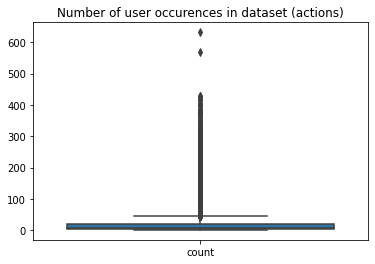

In [8]:
user_id_count = df_train.user_id.value_counts().reset_index(name="count").rename(columns={'index': 'user_id'})
sns.boxplot(data=user_id_count).set(title='Number of user occurences in dataset (actions)')

In [9]:
user_id_count.describe()

,count
count,563725.000000
mean,16.638361
std,23.612366
min,1.000000
25%,3.000000
50%,7.000000
75%,20.000000
max,632.000000


/var/folders/r8/3c5wqhdd503c57q35gcyk3b80000gn/T/ipykernel_84569/2490869866.py:22: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(patches, labels=user_id_groups['type'])


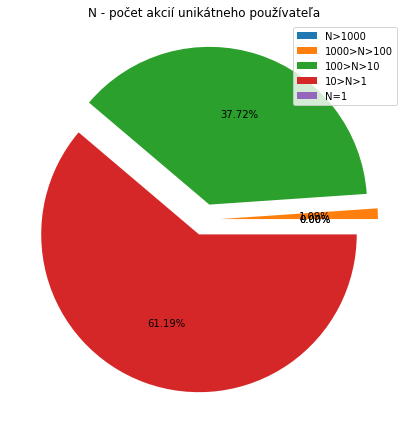

In [10]:
user_id_groups = pd.DataFrame({
    'type': [
        'N>1000',
        '1000>N>100',
        '100>N>10',
        '10>N>1',
        'N=1'
    ],
    'count': [
        user_id_count[user_id_count['count'] > 1000].count()[0],
        user_id_count[(user_id_count['count'] > 100) & (user_id_count['count'] < 1000)].count()[0],
        user_id_count[(user_id_count['count'] > 10) & (user_id_count['count'] < 100)].count()[0],
        user_id_count[(user_id_count['count'] > 1) & (user_id_count['count'] < 10)].count()[0],
        user_id_count[user_id_count['count'] == 1].count()[0]
    ]
});


pi,ax = plt.subplots(figsize=[10,6]);
plt.title("N - počet akcií unikátneho používateľa")
patches = plt.pie(x=user_id_groups['count'], explode=[0.1]*5, autopct="%.2f%%");
plt.legend(patches, labels=user_id_groups['type'])
plt.tight_layout();
plt.show();


Vidíme, že hodnoty sú distribuované dosť nízko, v jednotkách. Máme tu však aj outlierov, ktorí nám štatistiky ohýňajú. Väčšina používateľov však má len do 10 záznamov.

### Atribút session

Opäť ide o kategorický atribút. Vyjadruje unikátny identifikátor session.

In [11]:
len(df_train.session_id.unique())

681715

Zaujímavou štatistikou je napríklad, koľko má ktorý používateľ sessions, a určiť outlierov.

In [12]:
u_session_count = df_train.groupby(['user_id'])['session_id'].nunique().reset_index(name='count')
u_session_count

,user_id,count
0,0001VQMGUI65,1
1,0003QTCX5MJX,1
2,0004IOZI7CKF,1
3,0004WCFRV3FB,1
4,0008BO33KUQ0,3
...,...,...
563720,ZZZMUHLO5WBG,1
563721,ZZZOZKON2HVJ,1
563722,ZZZPQ336U50Y,1
563723,ZZZRFN2DZ2BV,1


In [13]:
u_session_count.describe()

,count
count,563725.000000
mean,1.209304
std,0.637925
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,51.000000


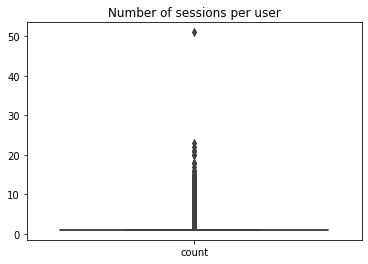

In [14]:
sns.boxplot(data=u_session_count).set(title="Number of sessions per user");

/var/folders/r8/3c5wqhdd503c57q35gcyk3b80000gn/T/ipykernel_84569/1737651595.py:19: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  patches = plt.legend(patches, labels=u_session_count_groups['type'])


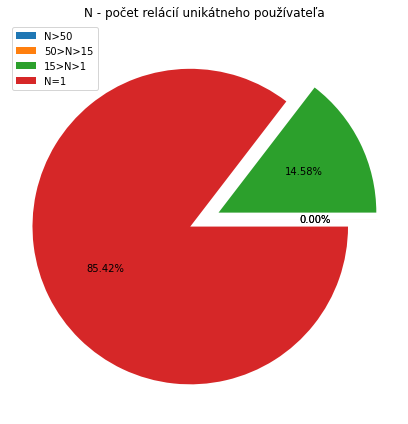

In [15]:
u_session_count_groups = pd.DataFrame({
    'type': [
        'N>50',
        '50>N>15',
        '15>N>1',
        'N=1'
    ],
    'count': [
        u_session_count[u_session_count['count'] > 50].count()[0],
        u_session_count[(u_session_count['count'] > 15) & (u_session_count['count'] < 50)].count()[0],
        u_session_count[(u_session_count['count'] > 1) & (u_session_count['count'] < 50)].count()[0],
        u_session_count[u_session_count['count'] == 1].count()[0],
    ]
});

pi,ax = plt.subplots(figsize=[10,6]);

plt.pie(x=u_session_count_groups['count'], explode=[0.1]*4, autopct="%.2f%%");
patches = plt.legend(patches, labels=u_session_count_groups['type'])
plt.title('N - počet relácií unikátneho používateľa')
plt.tight_layout()
plt.show()

Z grafu vidíme, že väčšina používateľov má jednu session.

#### Počet akcií (krokov) v jednej session

Zaujímalo by nás, koľko akcií je v priemere v jednej session.

In [16]:
session_action_count = df_train.groupby(['session_id'])['action_type'].count().reset_index(name="count")

In [17]:
session_action_count.describe()

,count
count,681715.000000
mean,13.758623
std,18.224146
min,1.000000
25%,3.000000
50%,6.000000
75%,16.000000
max,100.000000


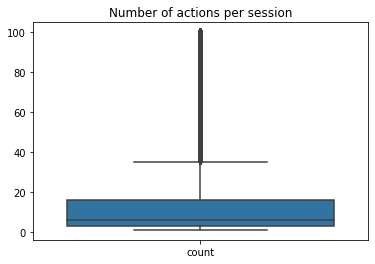

In [18]:
sns.boxplot(data=session_action_count).set(title="Number of actions per session");

/var/folders/r8/3c5wqhdd503c57q35gcyk3b80000gn/T/ipykernel_84569/3703885777.py:22: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(patches, labels=session_action_count_groups['type'])


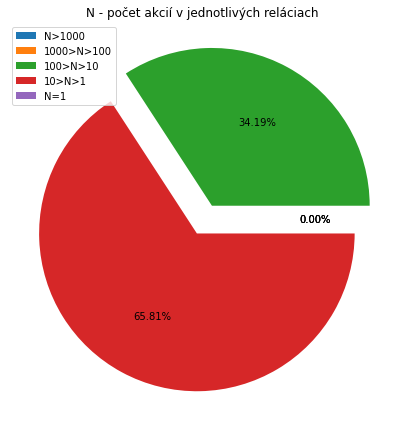

In [19]:
session_action_count_groups = pd.DataFrame({
   'type': [
        'N>1000',
        '1000>N>100',
        '100>N>10',
        '10>N>1',
        'N=1'
    ],
    'count': [
        session_action_count[session_action_count['count'] > 1000].count()[0],
        session_action_count[(session_action_count['count'] > 100) & (session_action_count['count'] < 1000)].count()[0],
        session_action_count[(session_action_count['count'] > 10) & (session_action_count['count'] < 100)].count()[0],
        session_action_count[(session_action_count['count'] > 1) & (session_action_count['count'] < 10)].count()[0],
        session_action_count[session_action_count['count'] == 1].count()[0]
    ]
});

pi,ax = plt.subplots(figsize=[10,6]);

plt.pie(x=session_action_count_groups['count'], explode=[0.1]*5, autopct="%.2f%%");
plt.title('N - počet akcií v jednotlivých reláciach ')
plt.legend(patches, labels=session_action_count_groups['type'])
plt.tight_layout()
plt.show();

Vidíme, že tu su už dáta pomerne pekne distribuované. Na grafe môžme vidieť, že necelá polovica sessions má od 1-10 akcií. Vyše štvrtina je v rozpätií 10-100. Necelá štvrtina sú single-step sessions. 

#### Dĺžka sessions

In [20]:
sessions_grouped = df_train.groupby(['session_id'])
sessions_grouped['timestamp'].agg(['first','last'])

,first,last
session_id,,
000056cd97ce2,1541483846,1541484101
000066611146f,1541332305,1541332330
00008c1f39c46,1541302205,1541302405
0000be39860d7,1541102752,1541104090
0000c0fb51e11,1541240881,1541240932
...,...,...
ptob1c1ag7444,1541438844,1541438888
qjhb1uuit1bda,1541431964,1541432134
s8u671odd7ckk,1541376805,1541376865


In [21]:
def min_max_diff(x):
    return x.max()-x.min()

def avg_step_duration(row):
    return row['session_length'] / row['steps']

def seconds_to_minutes(seconds):
    return round(seconds/60,2)

session_steps_length = sessions_grouped\
.agg(
    steps=('step','last'),
    session_length=('timestamp',min_max_diff),
)

In [22]:
# calculate avergate duration of step
session_steps_length['avg_step_duration_seconds'] = session_steps_length.apply(avg_step_duration,axis=1);

# transform session length into minutes
session_steps_length['session_length'] = session_steps_length['session_length'].apply(seconds_to_minutes);

session_steps_length

,steps,session_length,avg_step_duration_seconds
session_id,,,
000056cd97ce2,4,4.25,63.750000
000066611146f,3,0.42,8.333333
00008c1f39c46,4,3.33,50.000000
0000be39860d7,53,22.30,25.245283
0000c0fb51e11,5,0.85,10.200000
...,...,...,...
ptob1c1ag7444,20,0.73,2.200000
qjhb1uuit1bda,15,2.83,11.333333
s8u671odd7ckk,16,1.00,3.750000


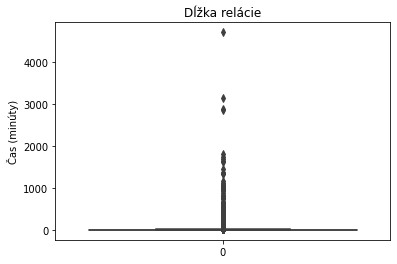

In [23]:
ax = sns.boxplot(data=session_steps_length.session_length).set(title="Dĺžka relácie",ylabel="Čas (minúty)");

### Atribút action_type

In [30]:
df_train.action_type.unique()

array(['search for poi', 'interaction item image', 'clickout item',
       'interaction item info', 'interaction item deals',
       'search for destination', 'filter selection',
       'interaction item rating', 'search for item',
       'change of sort order'], dtype=object)

In [31]:
actions_count = df_train['action_type'].value_counts().reset_index(name="count").rename(columns={'index':'action_type'})
actions_count

,action_type,count
0,interaction item image,5978429
1,clickout item,1316663
2,filter selection,584753
3,change of sort order,357452
4,search for destination,355806
5,interaction item info,210594
6,interaction item rating,165233
7,interaction item deals,155796
8,search for item,132913
9,search for poi,121821


/var/folders/r8/3c5wqhdd503c57q35gcyk3b80000gn/T/ipykernel_84569/67991065.py:5: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(patches, labels=actions_count['action_type'])


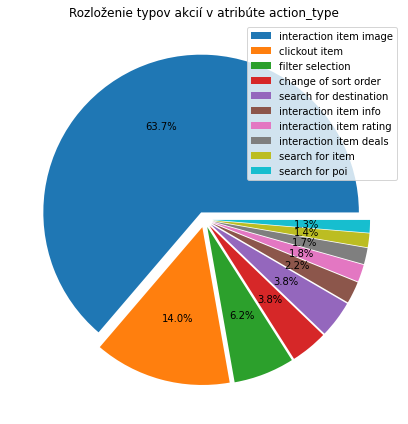

In [32]:
pi,ax = plt.subplots(figsize=[10,6]);

patches = plt.pie(x=actions_count['count'], explode=[0.05]*10, autopct="%.1f%%")
plt.title('Rozloženie typov akcií v atribúte action_type')
plt.legend(patches, labels=actions_count['action_type'])
plt.tight_layout()
plt.show()